# Tutorial for analyzing HP1alpha dimer slab simulation trajectory

In [29]:
# load packages
import numpy as np
import pandas as pd
import sys
import os
import mdtraj
import MDAnalysis
import networkx as nx
import matplotlib.pyplot as plt

sys.path.append('../../')
from openabc.utils.helper_functions import make_mol_whole, move_atoms_to_closest_pbc_image


We provide examples of how to analyze a slab simulation trajectory. Be careful that the simulations were performed under periodic boundary condition (PBC).

We present two example trajectories. One at 260 K and the other at 300 K (slab-traj/slab_260K.dcd and slab-traj/slab_300K.dcd). PBC box size is $25 \times 25 \times 400\ \text{nm}^3$. Only a fraction of the original trajectory files are presented as examples. 

In [30]:
# set some parameters
box_a, box_b, box_c = 25, 25, 400 # box lengths
n_monomers = 200 # monomer number
NA = 6.02214076e+23 # Avogadro constant

In [31]:
# analyze the trajectory
#traj = mdtraj.load_dcd('slab-traj/slab_260K.dcd', top='hp1alpha_100_dimers_CA.pdb')
traj = mdtraj.load_dcd('slab-traj/slab_300K.dcd', top='hp1alpha_100_dimers_CA.pdb')
n_frames = traj.n_frames
n_atoms = traj.n_atoms
n_atoms_per_monomer = int(n_atoms/n_monomers)

# make sure each monomer is intact (i.e. not broken apart by the box boundary)
intact_coord = np.zeros((n_frames, n_atoms, 3))
for i in range(n_frames):
    for j in range(n_monomers):
        coord_i_j = traj.xyz[i, j*n_atoms_per_monomer:(j + 1)*n_atoms_per_monomer].copy()
        intact_coord_i_j = make_mol_whole(coord_i_j, box_a, box_b, box_c)
        intact_coord[i, j*n_atoms_per_monomer:(j + 1)*n_atoms_per_monomer] = intact_coord_i_j

# compute center of mass (COM) coordinates based on intact coordinates (intact_coord)
# hp1alpha_dimer_CA.csv has atom mass information
df_dimer = pd.read_csv('hp1alpha_dimer_CA.csv')
monomer_mass = df_dimer['mass'].to_numpy()[:n_atoms_per_monomer]
intact_COM_coord = np.zeros((n_frames, n_monomers, 3))
for i in range(n_frames):
    for j in range(n_monomers):
        weights = monomer_mass/np.sum(monomer_mass)
        intact_COM_coord[i, j] = np.average(intact_coord[i, j*n_atoms_per_monomer:(j + 1)*n_atoms_per_monomer], axis=0, weights=weights)
intact_COM_coord = intact_COM_coord.astype(np.float32)

# find the largest cluster
# if the COMs of two monomers are within cutoff distance, then the two monomers are within the same cluster
# consider PBC when searching the largest cluster
cutoff = 5.0 # cutoff distance
pseudo_box = np.array([box_a, box_b, box_c, 90.0, 90.0, 90.0]).astype(np.float32) # orthogonal box
pbc = True

for i in range(n_frames):
    # find all the monomer neighbors (i.e. all the monomer pair that are within cutoff distance)
    grid_search = MDAnalysis.lib.nsgrid.FastNS(cutoff, intact_COM_coord[i], pseudo_box, pbc)
    results = grid_search.self_search()
    pairs = results.get_pairs()
    pairs = [(int(x[0]), int(x[1])) for x in pairs]
    # create a graph to find the largest cluster
    G = nx.Graph()
    G.add_nodes_from(list(range(n_monomers)))
    G.add_edges_from(pairs)
    largest_cluster = sorted(list(max(nx.connected_components(G), key=len)))
    print(f'Frame {i}, largest cluster includes {len(largest_cluster)} monomers. ')
    
    # then make sure the COMs in the largest cluster are within the same periodic image
    r0 = intact_COM_coord[i, largest_cluster[0]]
    r1 = intact_COM_coord[i, largest_cluster].copy()
    intact_COM_coord[i, largest_cluster] = move_atoms_to_closest_pbc_image(r1.copy(), r0, box_a, box_b, box_c)
    
    # update atom coordinates
    for j in range(len(largest_cluster)):
        k = largest_cluster[j]
        delta_r = intact_COM_coord[i, k] - r1[j]
        intact_coord[i, k*n_atoms_per_monomer:(k + 1)*n_atoms_per_monomer] += delta_r
    
    # translate all the atoms so the largest clsuter is at box center
    box_center = 0.5*np.array([box_a, box_b, box_c])
    delta_r = box_center - np.mean(intact_COM_coord[i, largest_cluster], axis=0)
    intact_coord[i, :] += delta_r
    intact_COM_coord[i, :] += delta_r

    # move all the monomers back to the main box
    r1 = intact_COM_coord[i].copy()
    intact_COM_coord[i] = move_atoms_to_closest_pbc_image(r1.copy(), box_center, box_a, box_b, box_c)
    for j in range(n_monomers):
        delta_r = intact_COM_coord[i, j] - r1[j]
        intact_coord[i, j*n_atoms_per_monomer:(j + 1)*n_atoms_per_monomer] += delta_r


Frame 0, largest cluster includes 197 monomers. 
Frame 1, largest cluster includes 69 monomers. 
Frame 2, largest cluster includes 77 monomers. 
Frame 3, largest cluster includes 101 monomers. 
Frame 4, largest cluster includes 78 monomers. 
Frame 5, largest cluster includes 107 monomers. 
Frame 6, largest cluster includes 109 monomers. 
Frame 7, largest cluster includes 100 monomers. 
Frame 8, largest cluster includes 29 monomers. 
Frame 9, largest cluster includes 70 monomers. 


Now the largest cluster has been moved to the center of the box. We draw the density profile averaged over the second half of the trajectory (the first half is dropped as the simulation needs time to relax). When using 300 K trajectory, the density profile looks rugged because we have too few frames here as example, and 300 K is close to the critical temperature. With more frames saved the density profile will look smoother. 

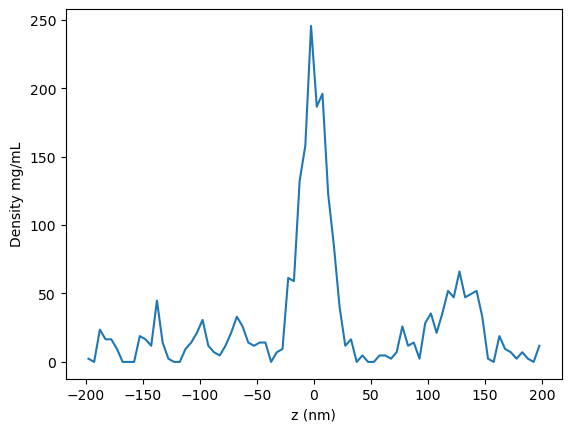

In [32]:
# draw density profile with the second half of the trajectory
bin_width = 5
n_bins = int(box_c/bin_width)
bins = np.linspace(0, box_c, n_bins + 1)
bin_width = bins[1] - bins[0] # reset bin_width
z = 0.5*(bins[1:] + bins[:-1])
z -= np.mean(z)
rho = []
for i in range(int(n_frames/2), n_frames):
    count_i, _ = np.histogram(intact_COM_coord[i, :, 2], bins=bins)
    rho_i = count_i*np.sum(monomer_mass)/(NA*box_a*box_b*bin_width*10**-27*10**3) # in unit g/L
    rho.append(rho_i)
rho = np.array(rho)
rho = np.mean(rho, axis=0)
plt.plot(z, rho)
plt.xlabel('z (nm)')
plt.ylabel('Density mg/mL')
plt.show()
